In [9]:
import requests
import pandas as pd
import lxml
from lxml import html
from DataRetrieval import get_sp500_tickers, get_sp500_table, get_avail_tickers
from bs4 import *
import pickle
from basic_analysis_toolkit import BasicAnalysis, get_closest_date
from risk_model_toolkit import *
from frm_model import *
import pandas_datareader as pdr
import math
from company_toolkit import *
import time 

risk_free_rates = pd.read_csv('treasury_3month_interest_rate.csv', parse_dates = ['DATE'], index_col = 'DATE').reindex(pd.date_range(datetime.date(day=1, month=1, year=2000), datetime.date(day=1, month=1, year=2020), freq='B'))

In [10]:
sp500 = pickle.load(open('stock_dataframe.pickle', 'rb'))
cd = pickle.load(open('company_dictionary.pickle', 'rb'))
frm = pickle.load(open('frm_2017_current.pickle', 'rb'))
start_frm = datetime.date(day=1, month=1, year=2017)
end_frm = datetime.date(day=1, month=9, year=2019)
def get_update_dataframe(start, company_dict):
    tickers = list(company_dict.keys())
    tickers.append('^GSPC')
    end = datetime.date.today()
    d = {}
    for ticker in tickers:
        df = pdr.DataReader([ticker], 'yahoo', start, end)
        d.update( df.to_dict() )
    return pd.DataFrame(d)

#update_df = get_update_dataframe(datetime.date(day=1, month=1, year=2008), cd)
#sp500 = get_update_dataframe(sp500.index[0], cd)
analysis = BasicAnalysis(sp500)
#frm = create_frm(analysis, cd, start_frm, end_frm)

In [11]:
ticker = 'SKX'
sector = cd.get('SKX').info.get('Sector')
sector_peers = get_sector_peers(cd, sector)

AttributeError: 'NoneType' object has no attribute 'info'

In [7]:
cd.get(ticker).forecast_naive_ov(datetime.date.today(), analysis)

,Operating Value,wacc,growth,scalability,profitability,Profitability Sensitivity,Sales Sensitivity,Growth Sensitivity,Wacc Sensitivity,Scalability Sensitivity
EA,-2.645358e+10,0.079338,0.042085,0.103102,0.193066,-4.648526,2.274795e-07,72.889798,-12.646396,-18.403838


In [8]:
analysis.calc_beta_adjusted(ticker, datetime.date.today())

0.8415869003094608

In [6]:
cd.get(ticker).forecast_naive_ov(datetime.date.today(), analysis)

,Operating Value,wacc,growth,scalability,profitability,Profitability Sensitivity,Sales Sensitivity,Growth Sensitivity,Wacc Sensitivity,Scalability Sensitivity
EA,-2.645358e+10,0.079338,0.042085,0.103102,0.193066,-4.648526,2.274795e-07,72.889798,-12.646396,-18.403838


In [7]:
# creating a table to compare it to it's sector peers
cd.get(ticker).get_fcffs_historical()
cd.get(ticker).profitability_analysis(cd)

,EA Estimate,EA 5 yr hist avg,Technology Avg
EBITDA Margin,0.204277,0.235623,0.195998
Depr/Sales,0.028687,0.032411,0.063371
Operating Margin,0.175590,0.203212,0.132627
Tax Rate,-0.310690,0.056991,1.061143
NOPAT Margin,0.230144,0.191630,-0.008109


In [8]:
historical_financials = cd.get(ticker).get_fcffs_historical().transpose()
nopat_margins = historical_financials['NOPAT']/historical_financials['Revenue']

In [9]:
nopat_margins

2016-03-31    0.150161
2017-03-31    0.202810
2018-03-31    0.240788
2019-03-31    0.178505
dtype: float64

In [10]:
end = datetime.date.today()
start = datetime.date.today() - datetime.timedelta(days=365 * 2)
closes = analysis.get_close(ticker, start, end, 'BM')
mr = analysis.get_percent_change(ticker, start, end, 'BM')

In [11]:
mr.plot()

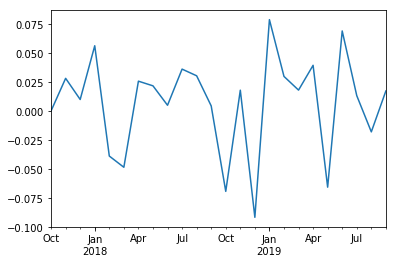

In [12]:

market_mr = analysis.get_percent_change('^GSPC', start, end, 'BM')
market_mr.plot()

In [13]:
ebitda_revenue = historical_financials['EBITDA']/historical_financials['Revenue']
costs_revenue = historical_financials['Operating Expense']/historical_financials['Revenue'] 

In [14]:
def get_residuals(self, ticker, start, end):
    beta = self.calc_beta_adjusted(ticker, end)
    predicted_returns = beta * self.get_percent_change('^GSPC', start, end, 'BM')
    return predicted_returns

In [15]:
get_residuals(analysis, ticker, start, end).mean()

0.005851939306070077

In [16]:
# creating the df for comparison
d = {}
get_industry = lambda ticker : cd.get(ticker).info.get('Industry')
industries = [get_industry(ticker) for ticker in sector_peers]
get_beta = lambda ticker : analysis.calc_beta_adjusted(ticker, end)
betas = [get_beta(ticker) for ticker in sector_peers]
get_profitability = lambda ticker : cd.get(ticker).get_profitability().mean()
profit_values = [get_profitability(ticker) for ticker in sector_peers]
get_waccs = lambda ticker : cd.get(ticker).calc_wacc(end, analysis)
waccs = [get_waccs(ticker) for ticker in sector_peers]
get_equity_multiplier = lambda ticker : cd.get(ticker).equity_multiplier().mean()
em = [get_equity_multiplier(ticker) for ticker in sector_peers]
get_debt_equity = lambda ticker : cd.get(ticker).debt_equity().mean()
de = [get_debt_equity(ticker) for ticker in sector_peers]
get_pb = lambda ticker : cd.get(ticker).price_book().mean()
pb = [get_pb(ticker) for ticker in sector_peers]
sector_df = pd.DataFrame({'Industries' : industries
                         ,'Betas' : betas
                         ,'Profit Margins' : profit_values
                         ,'WACCS': waccs
                         ,'Equity Multiplier' : em
                         ,'Debt Equity Ratio' : de
                         ,'Price Book' : pb}, 
                        index = sector_peers)

In [17]:
cd.get(ticker).info.get('Industry')

'Electronic Gaming & Multimedia'

In [18]:
get_profitability = lambda ticker : cd.get(ticker).get_profitability().mean()
profit_values = [get_profitability(ticker) for ticker in sector_peers]

In [19]:
sector_df.groupby('Industries').get_group('Electronic Gaming & Multimedia')

,Industries,Betas,Profit Margins,WACCS,Equity Multiplier,Debt Equity Ratio,Price Book
ATVI,Electronic Gaming & Multimedia,0.452870,0.091639,0.056550,1.836709,0.743665,2.494736
EA,Electronic Gaming & Multimedia,0.841587,0.193066,0.079338,1.881312,0.802809,3.624621
TTWO,Electronic Gaming & Multimedia,1.026066,0.023976,0.090155,3.045627,1.751989,4.271832


In [20]:
cd.get('ATVI').profitability_analysis(cd)

,ATVI Estimate,ATVI 5 yr hist avg,Technology Avg
EBITDA Margin,0.283877,0.240473,0.195998
Depr/Sales,0.067867,0.085060,0.063371
Operating Margin,0.216010,0.155413,0.132627
Tax Rate,0.172961,0.239166,1.061143
NOPAT Margin,0.178649,0.118244,-0.008109


In [21]:
monthly_returns_df = pd.DataFrame()
monthly_returns_df['ATVI'] = analysis.get_percent_change('ATVI', start, end, 'BM')
monthly_returns_df['EA'] = analysis.get_percent_change('EA', start, end, 'BM')
monthly_returns_df['TTWO'] = analysis.get_percent_change('TTWO', start, end, 'BM')

closes_df = pd.DataFrame()
closes_df['ATVI'] = analysis.get_close('ATVI', start, end, 'BM')
closes_df['EA'] = analysis.get_close('EA', start, end, 'BM')
closes_df['TTWO'] = analysis.get_close('TTWO', start, end, 'BM')


overall_returns_df = pd.DataFrame()
overall_returns_df['ATVI'] = analysis.get_return('ATVI', start, end, 'BM')
overall_returns_df['EA'] = analysis.get_return('EA', start, end, 'BM')
overall_returns_df['TTWO'] = analysis.get_return('TTWO', start, end, 'BM')

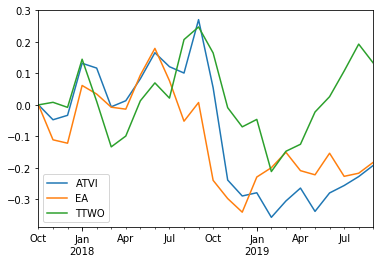

In [22]:
overall_returns_df.plot()

In [23]:
cd.get('TTWO').calc_wacc(datetime.date.today(), analysis)

0.0901545344167894

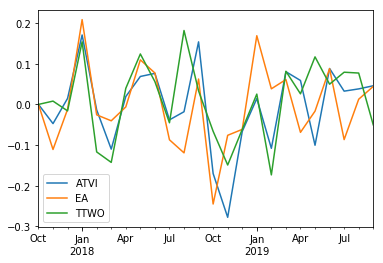

In [24]:
monthly_returns_df.plot()

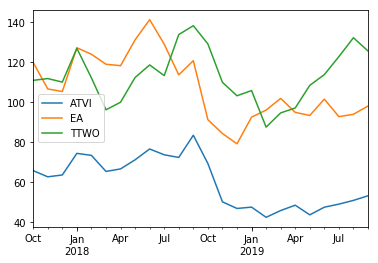

In [25]:
closes_df.plot()

In [26]:
cd.get('TTWO').eva_analysis(datetime.date.today(), analysis, cd)

,TTWO Estimate,TTWO Historical Avg,Technology Avg
RIC,0.137035,0.077233,-0.056826
WACC,0.090155,NaN,0.098193


In [27]:
get_residuals(analysis, 'TTWO', start, end).mean()

0.007134707059350411

In [28]:
get_residuals(analysis, 'ATVI', start, end).mean()

0.0031490093909221067

In [31]:
cd.get('ATVI').get_fcffs_historical()

,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00,2018-12-31 00:00:00
Revenue,4.664000e+06,6.608000e+06,7.017000e+06,7.500000e+06
Operating Expense,3.340000e+06,5.149000e+06,5.678000e+06,5.502000e+06
EBITDA,1.324000e+06,1.459000e+06,1.339000e+06,1.998000e+06
Depreciation,9.500000e+04,8.290000e+05,8.880000e+05,5.090000e+05
Other Income,-2.030000e+05,-3.530000e+05,-1.880000e+05,-1.210000e+05
EBIT,1.026000e+06,2.770000e+05,2.630000e+05,1.368000e+06
NOPAT,7.806162e+05,2.107511e+05,2.000995e+05,1.040822e+06
Change in NWC,NaN,1.398000e+06,6.830000e+05,6.070000e+05
CAPX,-1.110000e+05,-1.360000e+05,-1.550000e+05,-1.310000e+05
Other Investments,-3.559000e+06,-7.000000e+03,3.000000e+03,-6.000000e+03


In [32]:
cd.get(ticker).get_fcffs_historical()

,2016-03-31 00:00:00,2017-03-31 00:00:00,2018-03-31 00:00:00,2019-03-31 00:00:00
Revenue,4.396000e+06,4.845000e+06,5.150000e+06,4.950000e+06
Operating Expense,3.498000e+06,3.606000e+06,3.716000e+06,3.940000e+06
EBITDA,8.980000e+05,1.239000e+06,1.434000e+06,1.010000e+06
Depreciation,1.770000e+05,1.680000e+05,1.340000e+05,1.420000e+05
Other Income,-2.100000e+04,-2.900000e+04,1.500000e+04,6.900000e+04
EBIT,7.000000e+05,1.042000e+06,1.315000e+06,9.370000e+05
NOPAT,6.601060e+05,9.826150e+05,1.240056e+06,8.835991e+05
Change in NWC,NaN,8.480000e+05,7.290000e+05,6.030000e+05
CAPX,-9.300000e+04,-1.230000e+05,-1.070000e+05,-1.190000e+05
Other Investments,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [37]:
#cd.get(ticker).calc_wacc(datetime.date.today(), analysis)

In [42]:
cd.get(ticker).balance.columns

Index(['Cash And Cash Equivalents', 'Short Term Investments',
       'Net Receivables', 'Inventory', 'Other Current Assets',
       'Total Current Assets', 'Long Term Investments',
       'Property, plant and equipment', 'Goodwill', 'Intangible Assets',
       'Accumulated Amortization', 'Other Assets',
       'Deferred Long Term Asset Charges', 'Total Assets',
       'Current Liabilities', 'Accounts Payable',
       'Short/Current Long Term Debt', 'Other Current Liabilities',
       'Total Current Liabilities', 'Long Term Debt', 'Other Liabilities',
       'Deferred Long Term Liability Charges', 'Minority Interest',
       'Negative Goodwill', 'Total Liabilities', 'Stockholders' Equity',
       'Misc. Stocks Options Warrants', 'Redeemable Preferred Stock',
       'Preferred Stock', 'Common Stock', 'Retained Earnings',
       'Treasury Stock', 'Capital Surplus', 'Other Stockholder Equity',
       'Total stockholders' equity', 'Net Tangible Assets'],
      dtype='object', name=0)

In [8]:
pickle.dump(sp500, open('stock_dataframe.pickle', 'wb'))